In this notebook I attempt to implement a neural network from scratch, using nothing but numpy and python. Details are given below.

# Importing Libraries

In [1]:
# for classes
import numpy as np
# for generating synthetic datasets
from sklearn.datasets import make_classification, make_regression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
# for plotting
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Defining the Classes

The first class we define is the `layer` class. It contains the main functions and data that we would associate a layer to have.
It is advantageous to use classes since they provide a convenient way to bundle up associated functions and variables.

In [2]:
class layer():
    '''
    Class implementing a neural network layer.

    #############################################################################################################################
    
    INPUTS

    __init__
    
        n_units : number of units in layer.
        input_shape : shape of input. (num_units_in_prev_layer, num_examples) format.
        activation : the activation function to use (tanh, linear, softmax and relu supported).
        learning_rate: learning rate for gradient descent.

    forward_pass 

        A_in : The input activations to the neural network layer.

    backward_pass

        dJ_dA_out : The gradient of the cost, J, with respect to the output activation of the layer, A_out. 
                    This is computed either by seeding (at the last layer), or is passed from the next layer, during backprop.

    #############################################################################################################################
    
    FUNCTIONS

    __init__ (required by Python)
    
    init_parameters : initialize the parameters W, b for the layer. W is initialized to small random numbers while b is initialized to zeros.
    
    forward_pass : implements the forward pass through the layer.
    
    backward_pass : implements the backward pass through the layer, computing the associated gradients.
    
    update_parameters : implements one step of Gradient Descent, updating W, b.
    
    #############################################################################################################################
    
    OUTPUTS

    forward_pass : Returns A_out, the activation of the (current) layer.
    
    backward_pass: Returns dJ_dA_in, the gradient of the cost (J) with respect to the activation input to the layer during forward prop, A_in.
    
    #############################################################################################################################
    
    '''
    def __init__(self, n_units, input_shape, activation, learning_rate):
        
        self.n_units = n_units
        self.input_shape = input_shape
        self.activation = activation
        self.learning_rate = learning_rate
        
    def init_parameters(self):
        '''
        Initialize W, b
        '''
        W = np.random.randn(self.n_units, self.input_shape[0])*0.001
        b = 0.0
        self.W = W
        self.b = b

    def forward_pass(self, A_in):
        Z = np.dot(self.W, A_in) + self.b
        if (self.activation == 'linear'):
            A = Z
        elif (self.activation == 'relu'):
            A = np.maximum(0, Z)
        elif (self.activation == 'sigmoid'):
            A = 1.0/(1.0 + np.exp(-Z))
        elif (self.activation == 'tanh'):
            A = np.tanh(Z)
        elif (self.activation == 'softmax'):
            A = np.exp(Z)/np.sum(np.exp(Z), axis=0)
        else:
            raise ValueError("activation is not implemented!")
        self.Z = Z
        self.A_in = A_in
        self.A_out = A
        
        return A

    def backward_pass(self, dJ_dA_out):
        
        if (self.activation == 'linear'):
            dJ_dZ = dJ_dA_out
        elif (self.activation == 'relu'):
            dJ_dZ = dJ_dA_out * (self.Z > 0).astype(np.float64)
        elif (self.activation == 'sigmoid'):
            dJ_dZ = dJ_dA_out * self.A_out * (1 - self.A_out)
        elif (self.activation == 'tanh'):
            dJ_dZ = dJ_dA_out * (1 - (self.A_out * self.A_out))
        elif (self.activation == 'softmax'): 
            dJ_dZ = self.A_out * (dJ_dA_out - np.sum(dJ_dA_out * self.A_out, axis=0, keepdims=True))
        else:
            raise ValueError("activation is not implemented!")

        self.dJ_dW = np.dot(dJ_dZ, self.A_in.T)
        self.dJ_db = np.sum(dJ_dZ, axis=1, keepdims=True)
        dJ_dA_in = np.dot(self.W.T, dJ_dZ)

        return dJ_dA_in

    def update_parameters(self):
        self.W = self.W - self.learning_rate * self.dJ_dW
        self.b = self.b - self.learning_rate * self.dJ_db
        

In [3]:
class multiclass_classifier_nn():
    '''
    Class implementing a simple multi-class classifier using the `layer` class.

    #############################################################################################################################
    
    INPUTS

    __init__
    
        layers : a list containing the number of units in each layer, including the input layer.
        training_iterations : number of iterations to train the NN.
        learning_rate : the learning rate, passed to the component layers.

    train

        X : (n_features, m) matrix.
        Y : (n_classes, m) matrix.
        
        Where m is the number of training examples.

    predict_proba

        X : (n_features, m') matrix.

        Where m' is the number of (validation/test) examples. X here represents the validation/test input data, once the training
        is complete.

    #############################################################################################################################
    
    FUNCTIONS

    __init__ (required by Python)
    
    train : This function implements the following:
        (1) initialize the layers, and store them in a list called self.nn.
        (2) For `training_iterations` iterations, repeat:
        
            - Forward Pass
                For each layer in the NN, pass it the activations of the previous layer (X, the training data, for the first layer)
                and store the activations.
                
            - Compute Cost
                Also store the cost in a list called self.J_hist to be able to draw cost v/s iteration curves.
                
            - Backward Pass
                For each layer in the NN, going in reverse, pass it the gradient of the cost with respect to its activations.
                For the last layer (first in backprop), pass it dJ/dYhat where Yhat is the matrix of predicted values. Also,
                store this list of gradients.

            - Update parameters
                Once backprop is done, go back to each layer and call the update_parameters() function to update the W, b of each
                layer.

    predict_proba : given a (possibly unseen) set `X` (which need **not** be the same as the training set `X` passed to `train`),
                    run forward propagation on the neural network and return the output of the final layer,
                    i.e., Yhat, the prediction of the neural network.
        
    
    
    #############################################################################################################################
    
    OUTPUTS

    train : self.nn, self.J_hist - the list of (trained) layers forming the neural network, as well as the list storing the cost after each
            training iteration.
    
    predict_proba : Return the prediction of the neural network, that is, the activation of the last layer. It is also called Yhat.
    
    #############################################################################################################################
    '''
    
    def __init__(self, layers, training_iterations, learning_rate):        
        self.layers = layers
        self.training_iterations = training_iterations 
        self.learning_rate = learning_rate
        self.nn = [] # list of layers making up the neural network
        self.J_hist = [] # costs history
    def train(self, X, Y):
        
        assert X.shape[1] == Y.shape[1]
        
        n_features = X.shape[0]
        n_classes = Y.shape[0]
        m = X.shape[1] 

        # initialize the layers.
        for i in range(1, len(self.layers)):
            if (i != len(self.layers) - 1):
                l = layer(n_units = self.layers[i], input_shape=[self.layers[i-1],m], activation='relu', learning_rate = self.learning_rate)
                l.init_parameters()
                self.nn.append(l)
            else:
                l = layer(n_units = self.layers[i], input_shape=[self.layers[i-1],m], activation='softmax', learning_rate = self.learning_rate)
                l.init_parameters()
                self.nn.append(l)
        
        assert len(self.nn) == len(self.layers)-1

        
        for n_iter in range(self.training_iterations):
        
            # forward propagation
            A_l = [X]
            for l in self.nn:
                A_l.append(l.forward_pass(A_l[-1]))
    
            # compute cost
            J = -np.sum(Y*np.log(A_l[-1]))/m
            self.J_hist.append(J)
            
            # backprop
            dJ_dA_l = [-(Y/A_l[-1])/m]
            for l in reversed(self.nn):
                dJ_dA_l.append(l.backward_pass(dJ_dA_l[-1]))
    
            # update
            for l in self.nn:
                l.update_parameters()

        return self.nn, self.J_hist

    def predict_proba(self, X):
        '''
        predict class probabilities.
        '''
        A_l = [X]
        for l in self.nn:
            A_l.append(l.forward_pass(A_l[-1]))
        return A_l[-1]
        
        

In [4]:
class regression_classifier_nn():
    '''
    Class implementing a simple regressor using the `layer` class.

    #############################################################################################################################
    
    INPUTS

    __init__
    
        layers : a list containing the number of units in each layer, including the input layer.
        training_iterations : number of iterations to train the NN.
        learning_rate : the learning rate, passed to the component layers.

    train

        X : (n_features, m) matrix.
        Y : (n_classes, m) matrix.
        
        Where m is the number of training examples.

    predict_proba

        X : (n_features, m') matrix.

        Where m' is the number of (validation/test) examples. X here represents the validation/test input data, once the training
        is complete.

    #############################################################################################################################
    
    FUNCTIONS

    __init__ (required by Python)
    
    train : This function implements the following:
        (1) initialize the layers, and store them in a list called self.nn.
        (2) For `training_iterations` iterations, repeat:
        
            - Forward Pass
                For each layer in the NN, pass it the activations of the previous layer (X, the training data, for the first layer)
                and store the activations.
                
            - Compute Cost
                Also store the cost in a list called self.J_hist to be able to draw cost v/s iteration curves.
                
            - Backward Pass
                For each layer in the NN, going in reverse, pass it the gradient of the cost with respect to its activations.
                For the last layer (first in backprop), pass it dJ/dYhat where Yhat is the matrix of predicted values. Also,
                store this list of gradients. =

            - Update parameters
                Once backprop is done, go back to each layer and call the update_parameters() function to update the W, b of each
                layer.

    predict : given a (possibly unseen) set `X` (which need **not** be the same as the training set `X` passed to `train`),
                    run forward propagation on the neural network and return the output of the final layer,
                    i.e., Yhat, the prediction of the neural network.
        
    
    
    #############################################################################################################################
    
    OUTPUTS

    train : self.nn, self.J_hist - the list of (trained) layers forming the neural network, as well as the list storing the cost after each
            training iteration.
    
    predict : Return the prediction of the neural network, that is, the activation of the last layer. It is also called Yhat.
    
    #############################################################################################################################
    '''
    def __init__(self, layers, training_iterations, learning_rate):        
        self.layers = layers # a list containing the number of units in each layer, including the input layer.
        self.training_iterations = training_iterations # number of iterations to train the NN.
        self.learning_rate = learning_rate
        self.nn = []
        self.J_hist = [] # costs history
    def train(self, X, Y):
        '''
        X -> (n_features, m) matrix.
        Y -> (n_classes, m) matrix.
        '''
        assert X.shape[1] == Y.shape[1]
        
        n_features = X.shape[0]
        m = X.shape[1] # n_examples

        # make sure that the neural network outputs only one number.
        assert self.layers[-1] == 1 
        # make sure that the output is of the shape (1, m)
        assert Y.shape[0] == 1
        assert Y.shape[1] == m
        
        for i in range(1, len(self.layers)):
            if (i != len(self.layers) - 1):
                l = layer(n_units = self.layers[i], input_shape=[self.layers[i-1],m], activation='relu', learning_rate = self.learning_rate)
                l.init_parameters()
                self.nn.append(l)
            else:
                
                l = layer(n_units = self.layers[i], input_shape=[self.layers[i-1],m], activation='linear', learning_rate = self.learning_rate)
                l.init_parameters()
                self.nn.append(l)
        
        assert len(self.nn) == len(self.layers)-1

        
        for n_iter in range(self.training_iterations):
        
            # forward propagation
            A_l = [X]
            for l in self.nn:
                A_l.append(l.forward_pass(A_l[-1]))
    
            # compute cost
            J = np.sum((A_l[-1] - Y)**2.0, axis=1)/(2.0*m)
            self.J_hist.append(J)
            
            # backprop
            dJ_dA_l = [(A_l[-1] - Y)/m]
            for l in reversed(self.nn):
                dJ_dA_l.append(l.backward_pass(dJ_dA_l[-1]))
    
            # update
            for l in self.nn:
                l.update_parameters()

        return self.nn, self.J_hist

    def predict(self, X):
        '''
        predict Yhat.
        '''
        A_l = [X]
        for l in self.nn:
            A_l.append(l.forward_pass(A_l[-1]))
        return A_l[-1]
        
        

# Generating Synthetic Data for Regression and Classification

In [5]:
def generate_synthetic_classification_data(n_samples=1000, n_features=2, n_classes=3, random_state=42):
    
    X, y = make_classification(
        n_samples=n_samples,
        n_features=n_features,
        n_informative=n_features,
        n_redundant=0,
        n_clusters_per_class=1,
        n_classes=n_classes,
        random_state=random_state
    )
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    X = X.T
    
    encoder = OneHotEncoder()
    y_one_hot = encoder.fit_transform(y.reshape(-1, 1)).T.toarray()
    
    return X, y_one_hot


Xc, Yc = generate_synthetic_classification_data()
print("Xc shape: ", Xc.shape, "Yc shape: ", Yc.shape)

Xc shape:  (2, 1000) Yc shape:  (3, 1000)


In [6]:
def generate_synthetic_regression_data(n_samples=1000, n_features=1, noise=5, random_state=42):
    
    X, y = make_regression(
        n_samples=n_samples,
        n_features=n_features,
        noise=noise,
        random_state=random_state
    )
    
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    X = X.T
    
    y = y.reshape(1, -1)
    
    return X, y


Xr, Yr = generate_synthetic_regression_data()
print("Xr shape: ", Xr.shape, "Yr shape: ", Yr.shape)

Xr shape:  (1, 1000) Yr shape:  (1, 1000)


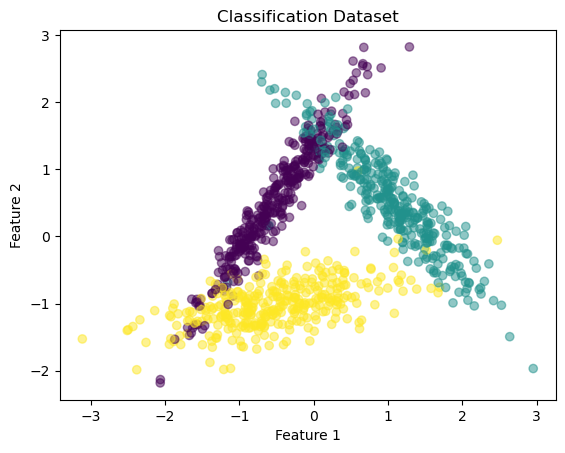

In [7]:
plt.scatter(Xc[0, :], Xc[1,:], c=np.argmax(Yc, axis=0), alpha=0.5)
plt.title("Classification Dataset")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

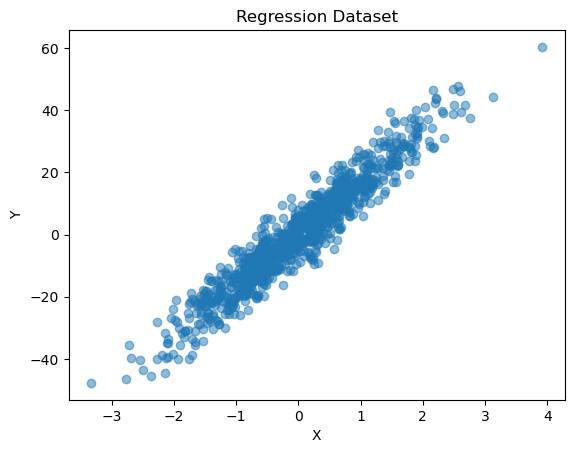

In [8]:
plt.scatter(Xr[0, :], Yr[0,:], alpha=0.5)
plt.title("Regression Dataset")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

# Running Regression and Classification

In [9]:
reg = regression_classifier_nn(layers = [1, 10, 1], training_iterations = 2_000, learning_rate = 0.005)

In [10]:
_, cost_hist_reg = reg.train(Xr, Yr)

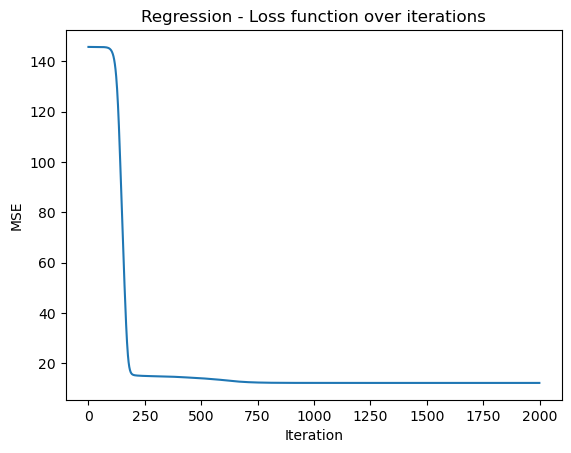

In [11]:
plt.plot(cost_hist_reg)
plt.title("Regression - Loss function over iterations")
plt.ylabel("MSE")
plt.xlabel("Iteration")
plt.show()

In [12]:
clf = multiclass_classifier_nn(layers = [2, 5, 3],  training_iterations = 1_000, learning_rate = 0.1)

In [13]:
_, cost_hist_clf = clf.train(Xc, Yc)

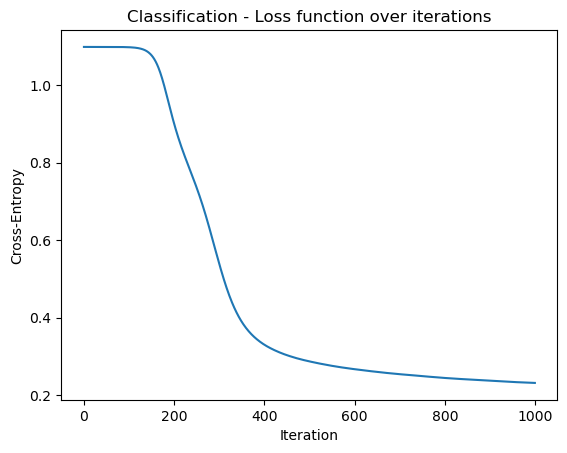

In [14]:
plt.plot(cost_hist_clf)
plt.title("Classification - Loss function over iterations")
plt.ylabel("Cross-Entropy")
plt.xlabel("Iteration")
plt.show()

# Plotting Decision Regions and Regression Line

In [15]:
def plot_regression_line(X, Y, f, resolution=0.01):
    
    # X must have shape (1, m)
    # Y must have shape (1, m)
    m = X.shape[1]
    assert X.shape[0] == 1
    assert Y.shape[0] == 1
    assert Y.shape[1] == m
    
    X = X.flatten() 
    Y = Y.flatten()
    
    x_min, x_max = X.min() - 1, X.max() + 1
    
    x_values = np.arange(x_min, x_max, resolution)
    y_values = f(x_values.reshape(1, -1)).flatten()
    
    plt.scatter(X, Y, color='blue', edgecolor='k', s=50, alpha=0.6, label="Data Points")
    plt.plot(x_values, y_values, color='red', linewidth=2, label="Regression Line")
    
    # Set plot limits
    plt.xlim(x_min, x_max)
    plt.ylim(Y.min() - 1, Y.max() + 1)
    
    plt.title("Regression Line and Data Points")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend()
    plt.show()



def plot_decision_boundaries(X, Y, f, resolution=0.01):
    
    # X must have shape (n_features, m)
    # Y must have shape (n_classes, m)
    m = X.shape[1]
    assert Y.shape[1] == m
    
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, resolution),
                         np.arange(y_min, y_max, resolution))
    grid_points = np.c_[xx.ravel(), yy.ravel()].T
    Yhat = f(grid_points) 
    
    Z = np.argmax(Yhat, axis=0)
    Z = Z.reshape(xx.shape)
    
    # Plot the decision boundary
    colors = ['lightblue', 'lightgreen', 'lightcoral']
    cmap_background = ListedColormap(colors)
    plt.contourf(xx, yy, Z, cmap=cmap_background)
    
    
    
    # Plot the points, colored by their true class
    cmap_points = ListedColormap(['blue', 'green', 'red'])
    plt.scatter(X[0, :], X[1, :], c=np.argmax(Y, axis=0), cmap=cmap_points, edgecolor='k', s=50, alpha=0.1)
    
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("Decision Boundaries and Data Points")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.show()



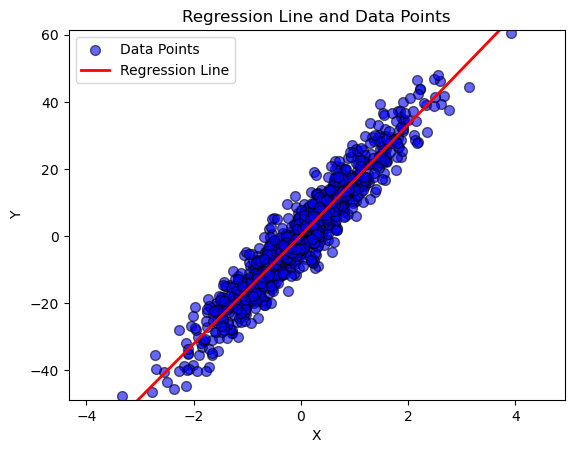

In [16]:
plot_regression_line(Xr, Yr, f=reg.predict)

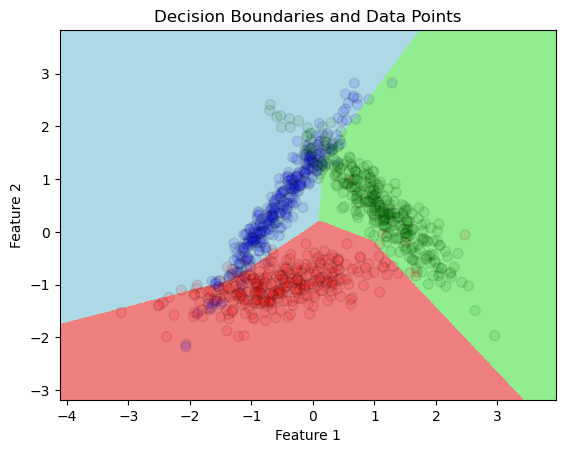

In [17]:
plot_decision_boundaries(Xc, Yc, clf.predict_proba)

# Closing Remarks and References

Note that in this notebook we have **not** focused on the performance of these NNs, and we do not even have a train/val/test set split to evaluate the models. This is because the focus of this notebook is to show the built neural networks, not evaluate their use for practical applications. After all, this implementation has a few quirks (using lists to store activations and their gradients, for instance, which is not necessary, or storing *all* the costs during training, which may lead to memory issues when training for longer number of iterations), and is not designed with performance in mind. 
Nonetheless, we can visually confirm that the training algorithm is working - at least on the training set, the neural networks are able to capture patterns in the data quite well. Moreover, the cost function decreases as a function of the number of iterations, which is exactly what we expect for a well-functioning neural network.

An excellent resource I referred to are these three blog posts on feedforward neural networks:

- [Feedforward Neural Networks in Depth, Part 1: Forward and Backward Propagations](https://jonaslalin.com/2021/12/10/feedforward-neural-networks-part-1/)
- [Feedforward Neural Networks in Depth, Part 2: Activation Functions](https://jonaslalin.com/2021/12/21/feedforward-neural-networks-part-2/)
- [Feedforward Neural Networks in Depth, Part 3: Cost Functions](https://jonaslalin.com/2021/12/22/feedforward-neural-networks-part-3/)

I highly recommend checking them out.